<b>Deep Learning @ CYCU2023</b><br/>
# <b>Deep Learning: Using RNN & LSTM to Predict Stock Price</b>
<b>Assist. Prof. Chun-Hsiang Chan</b><br/>
Undergraduate Program in Intelligent Computing and Big Data, Chung Yuan Christian University<br/>
Master Program in Intelligent Computing and Big Data, Chung Yuan Christian University

### <b>Initialization</b>

In [1]:
# import packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
import os

### <b>Load and Prepare Dataset</b>

In [2]:
# load data and preview the top 5 rows of dataset
os.chdir('Dataset/')
data = pd.read_csv('Tesla.csv')
data.head()

Date       Open   High        Low      Close    Volume  Adj Close
0  6/29/2010  19.000000  25.00  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.42  23.299999  23.830000  17187100  23.830000
2   7/1/2010  25.000000  25.92  20.270000  21.959999   8218800  21.959999
3   7/2/2010  23.000000  23.10  18.709999  19.200001   5139800  19.200001
4   7/6/2010  20.000000  20.00  15.830000  16.110001   6866900  16.110001

In [3]:
# print out the dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [4]:
# get the number of rows in the dataset
length_data = len(data)

# get the spliting proportion of training and testing dataset
# 0.7 indicates that 70% training and 30% testing
split_ratio = 0.7

# get the number of rows for training and testing
length_train = round(length_data * split_ratio)  
length_testing = length_data - length_train

# print the information
print('Data length :', length_data)
print('Train data length :', length_train)
print('Testing data lenth :', length_testing)

Data length : 1692
Train data length : 1184
Testing data lenth : 508


In [5]:
# split data for training
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data.head()

Date       Open
0 2010-06-29  19.000000
1 2010-06-30  25.790001
2 2010-07-01  25.000000
3 2010-07-02  23.000000
4 2010-07-06  20.000000

In [6]:
# split data for testing
testing_data = data[length_train:].iloc[:,:2]
testing_data['Date'] = pd.to_datetime(testing_data['Date'])  # converting to date time object
testing_data.head()

Date        Open
1184 2015-03-13  188.949997
1185 2015-03-16  192.000000
1186 2015-03-17  195.429993
1187 2015-03-18  194.960007
1188 2015-03-19  202.000000

In [7]:
# get Open (開盤) data and reshape from 1d array to 2d array
dataset_train = train_data.Open.values
print('before reshape:',dataset_train.shape)

dataset_train = np.reshape(dataset_train, (-1,1))
print('after reshape:',dataset_train.shape)
# dataset_train # for preview

before reshape: (1184,)
after reshape: (1184, 1)


In [8]:
# adjust the value scale with feature scaling (i.e., (x-min)/(max-min))
scaler = MinMaxScaler(feature_range = (0,1))

# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

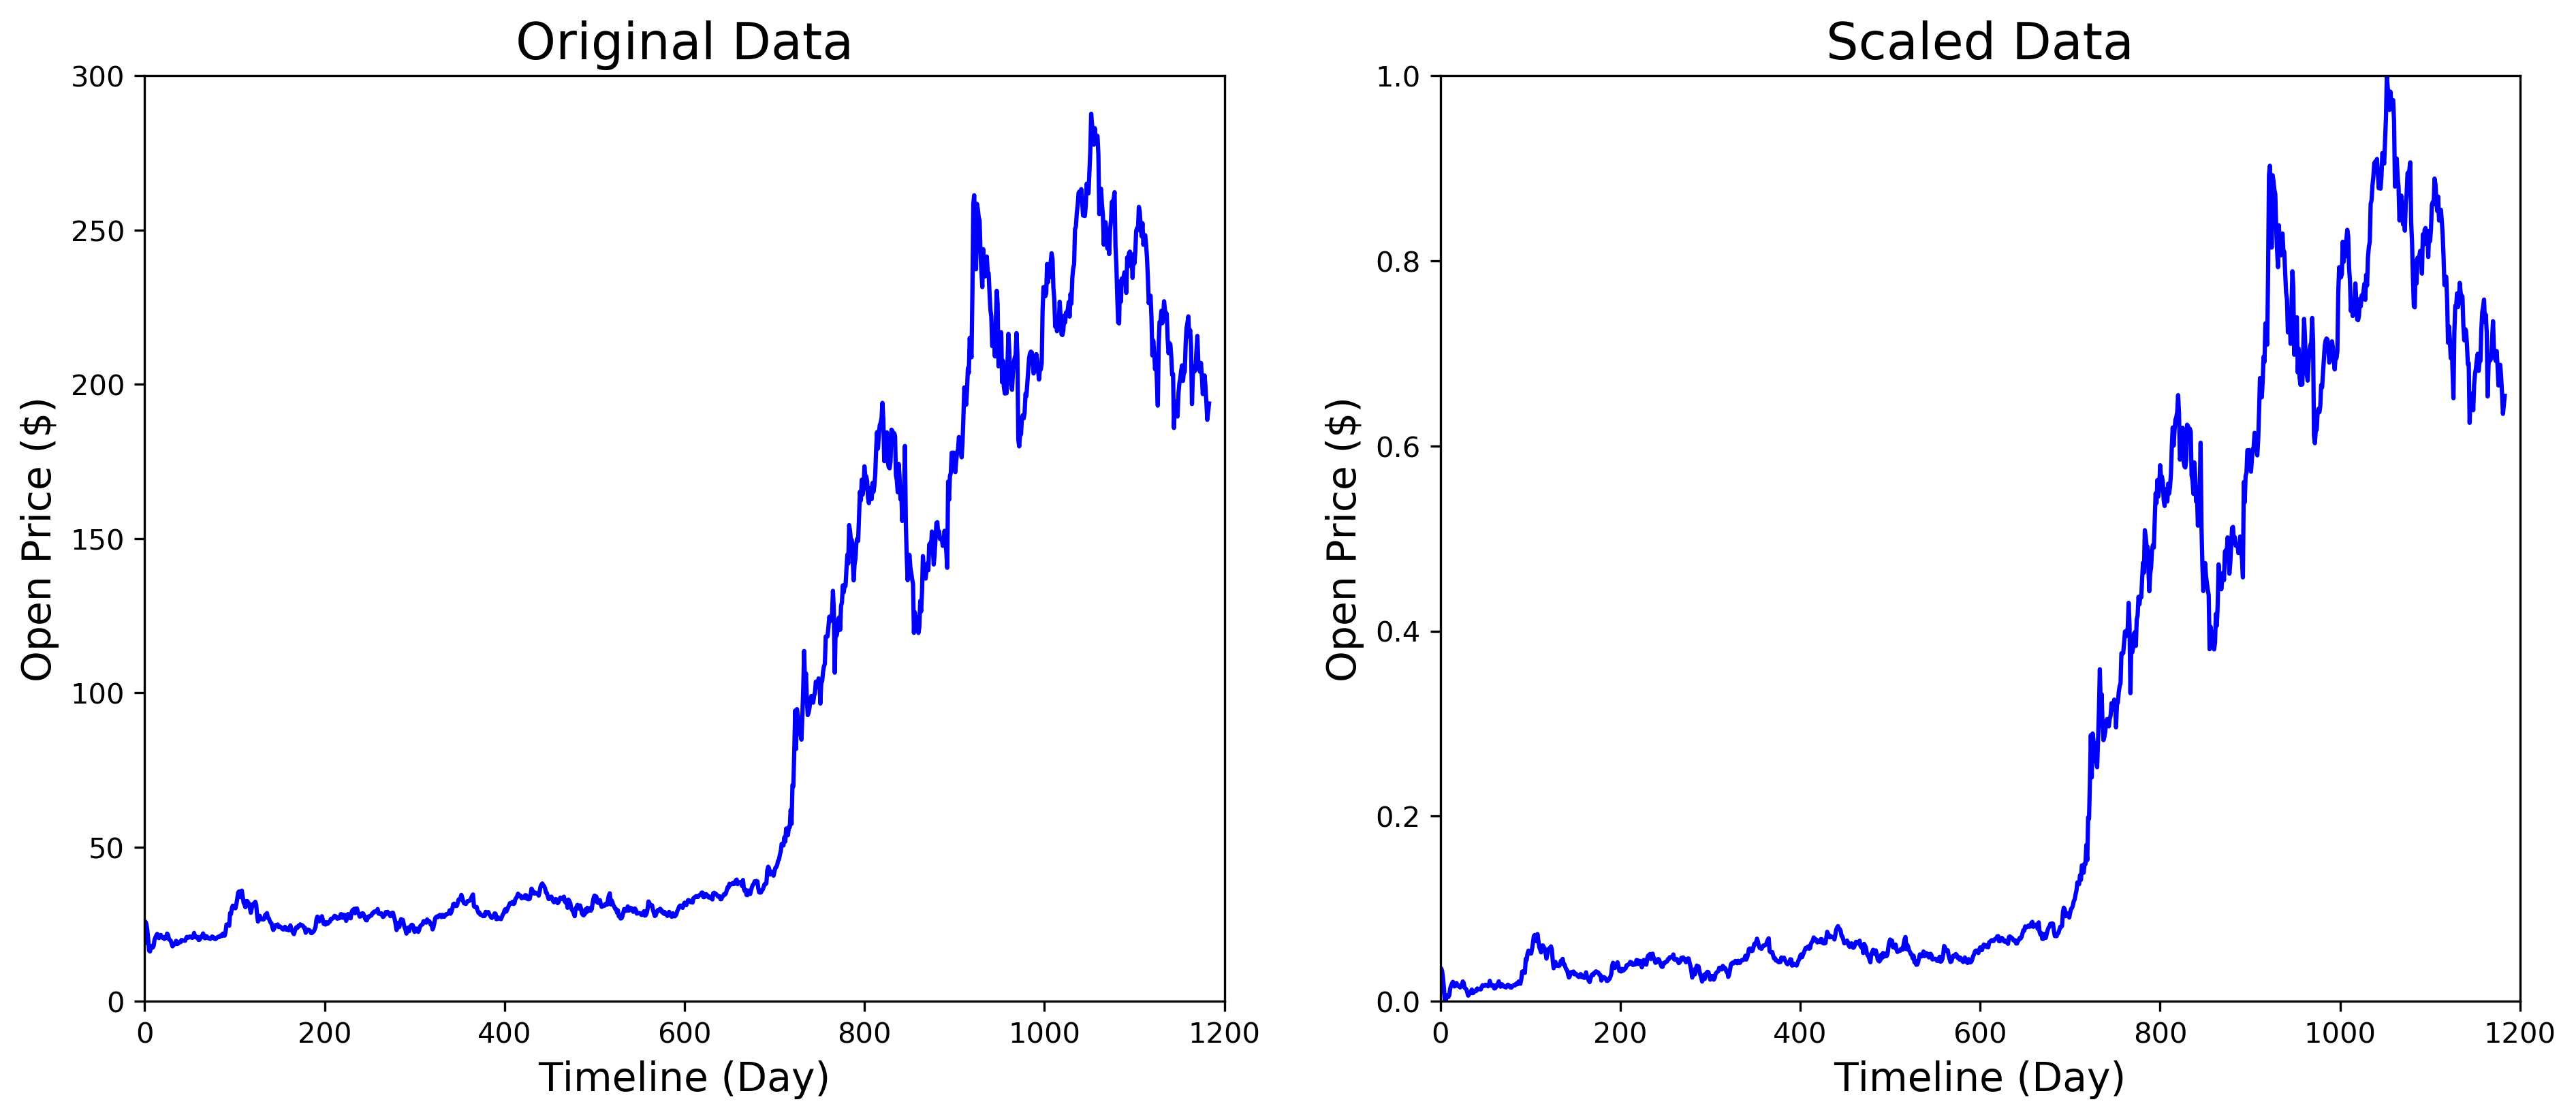

In [9]:
# preview the scaled data
plt.subplots(figsize = (15,6), dpi=300)
plt.subplot(121)
plt.plot(dataset_train, 'b')
plt.title('Original Data', fontsize=18)
plt.xlabel('Timeline (Day)', fontsize=14)
plt.ylabel('Open Price ($)', fontsize=14)
plt.axis([0,1200,0,300])

plt.subplot(122)
plt.plot(dataset_train_scaled, 'b')
plt.title('Scaled Data', fontsize=18)
plt.xlabel('Timeline (Day)', fontsize=14)
plt.ylabel('Open Price ($)', fontsize=14)
plt.axis([0,1200,0,1])
plt.show()

In [10]:
# model design
# our objective is to predict the tomorrow Open price by using prior 30 days data (month)
X_train = []
y_train = []

# set up the prior date range
time_step = 30

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

# print the shape information
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (1154, 30)
Shape of y_train before reshape : (1154,)


In [11]:
# reshape for analyzing
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print('Shape of X_train after reshape :',X_train.shape)
print('Shape of y_train after reshape :',y_train.shape)

Shape of X_train after reshape : (1154, 30, 1)
Shape of y_train after reshape : (1154, 1)


### <b>Build Simple RNN Model</b>

In [12]:
# import packages for RNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

In [13]:
# initialize the RNN model
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 30, activation = 'tanh', return_sequences = True, 
              input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# adding second RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 30, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# adding third RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 30, activation = 'tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# adding fourth RNN layer and dropout regulatization
regressor.add(SimpleRNN(units = 30))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics = ['accuracy'])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
37/37 [==============================] - 2s 9ms/step - loss: 0.3072 - accuracy: 0.0000e+00
Epoch 2/50
37/37 [==============================] - 0s 9ms/step - loss: 0.1415 - accuracy: 0.0000e+00
Epoch 3/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0913 - accuracy: 0.0000e+00
Epoch 4/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.0000e+00
Epoch 5/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0606 - accuracy: 8.6655e-04
Epoch 6/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0463 - accuracy: 8.6655e-04
Epoch 7/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.0000e+00
Epoch 8/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0369 - accuracy: 8.6655e-04
Epoch 9/50
37/37 [==============================] - 0s 8ms/step - loss: 0.0337 - accuracy: 8.6655e-04
Epoch 10/50
37/37 [==============================] - 0s 9ms/step - loss: 0.0276 - 

In [14]:
# Losses
history.history['loss']

[0.307227224111557,
 0.14150016009807587,
 0.09127699583768845,
 0.06916377693414688,
 0.060623254626989365,
 0.046276748180389404,
 0.03891346976161003,
 0.036930181086063385,
 0.033691395074129105,
 0.027614327147603035,
 0.025091096758842468,
 0.02348373457789421,
 0.02418324537575245,
 0.018832117319107056,
 0.0173568706959486,
 0.017359109595417976,
 0.01630101539194584,
 0.01631942391395569,
 0.013181328773498535,
 0.014427737332880497,
 0.01236166711896658,
 0.01145122293382883,
 0.010941481217741966,
 0.010945089161396027,
 0.010520455427467823,
 0.009645037353038788,
 0.008697833865880966,
 0.009636587463319302,
 0.008719544857740402,
 0.00896483100950718,
 0.008453665301203728,
 0.008485496044158936,
 0.007989944890141487,
 0.007956198416650295,
 0.007894640788435936,
 0.0062909540720283985,
 0.006202896125614643,
 0.006348700728267431,
 0.006045756861567497,
 0.005969217047095299,
 0.005849447567015886,
 0.0060437386855483055,
 0.005421253386884928,
 0.005467413458973169,
 0

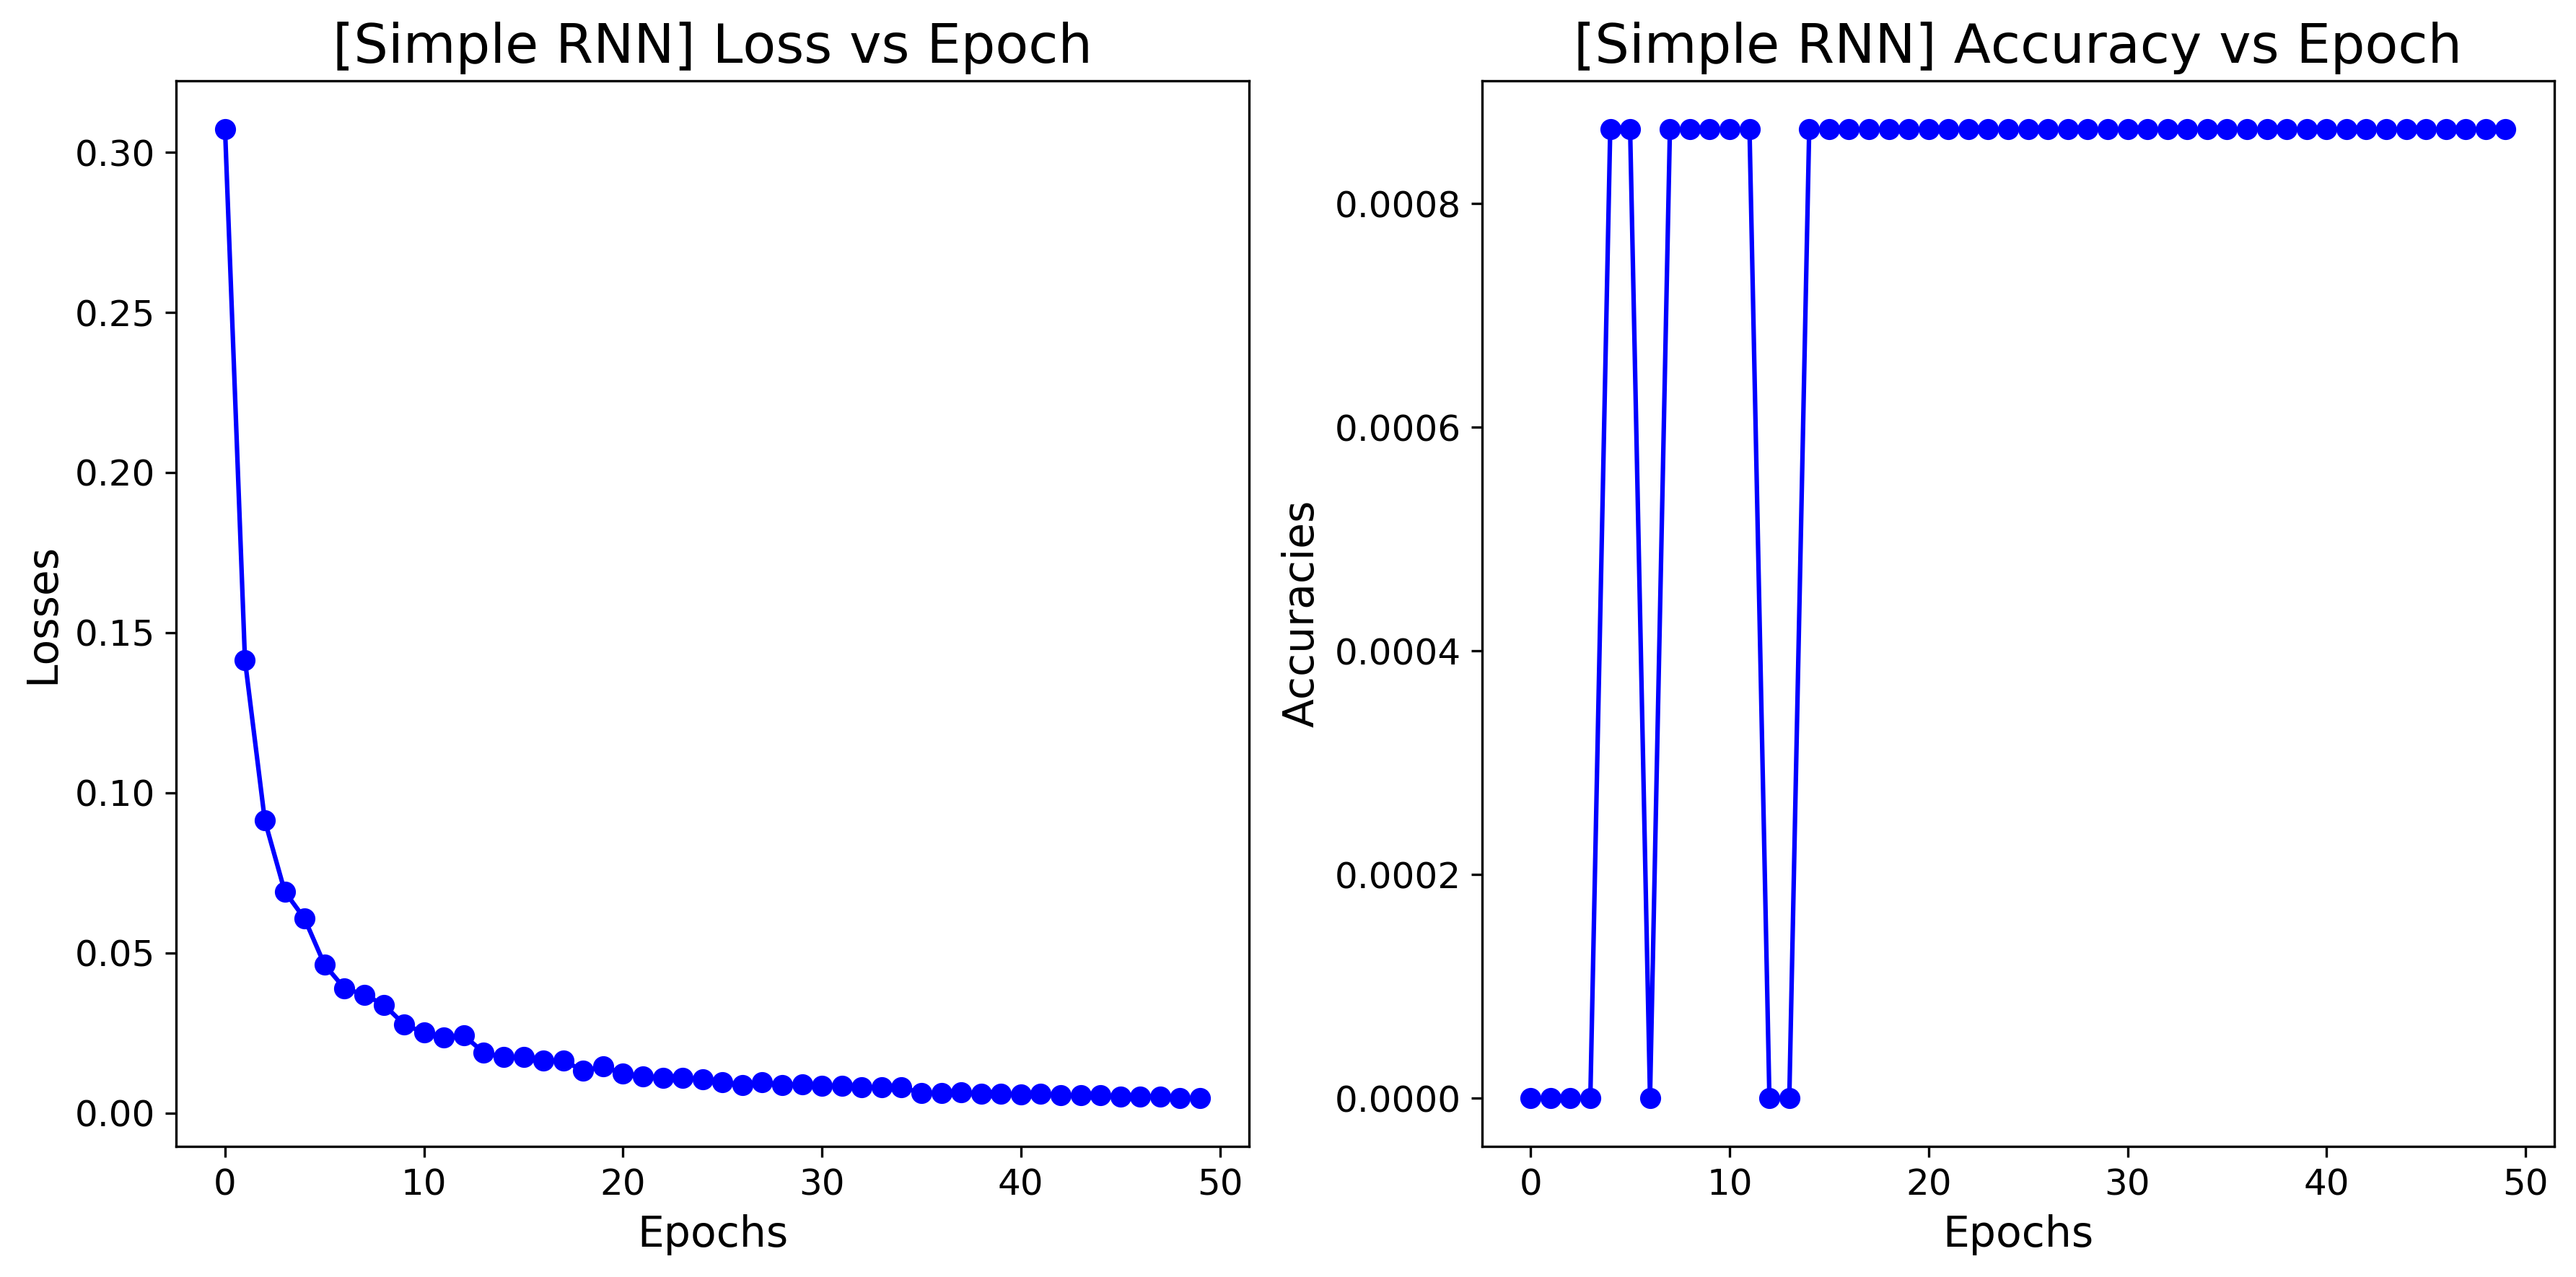

In [15]:
# plot loss and accuracy vs epochs
plt.figure(figsize =(12,6), dpi=300)
plt.subplot(121)
plt.plot(history.history['loss'],'bo-')
plt.title('[Simple RNN] Loss vs Epoch', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Losses', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(122)
plt.plot(history.history['accuracy'],'bo-')
plt.title('[Simple RNN] Accuracy vs Epoch', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracies', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

### <b>Predict the Training Data</b>

In [16]:
# predict data by using trained RNN model
y_pred = regressor.predict(X_train)
# scale back from 0-1 to original scale
y_pred_ = scaler.inverse_transform(y_pred)
y_pred_.shape

(1154, 1)

In [17]:
# scale back from 0-1 to original scale
y_train_ = scaler.inverse_transform(y_train)
y_train_.shape

(1154, 1)

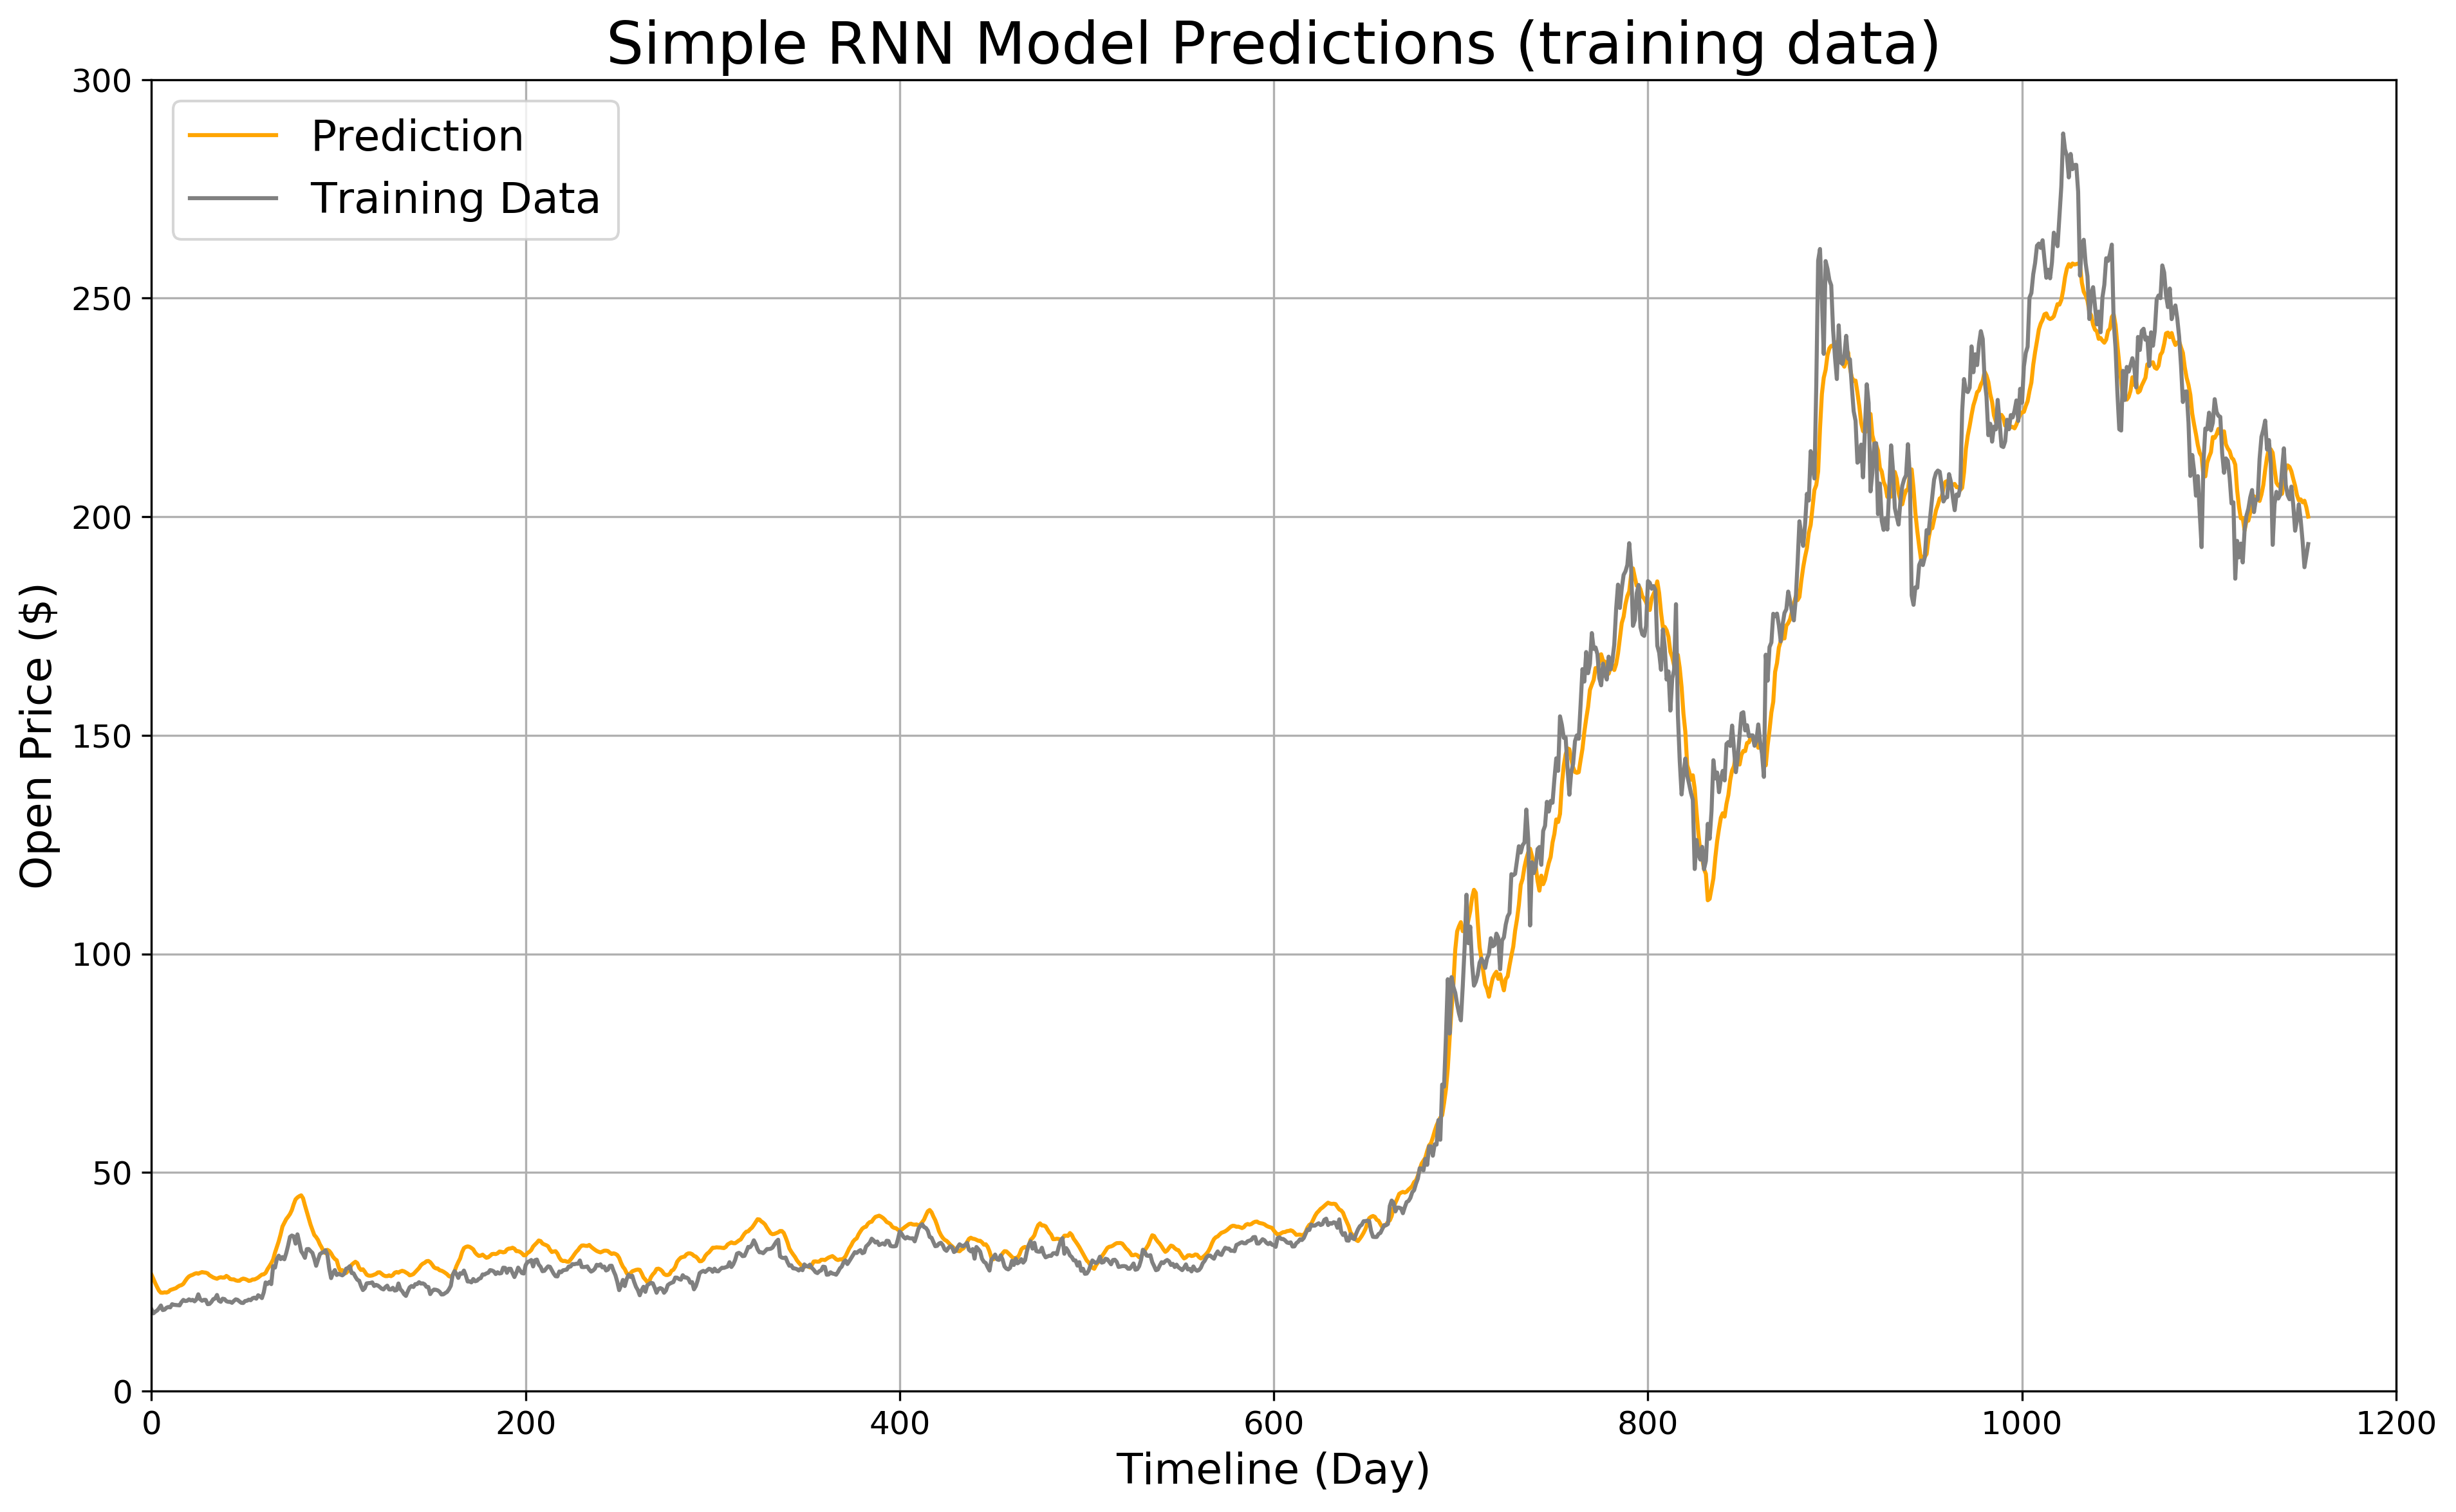

In [18]:
# present the prediction result with ground truth data (training only)
plt.figure(figsize = (15,9), dpi=300)
plt.plot(y_pred_, 'orange', label = 'Prediction')
plt.plot(y_train_, 'gray', label = 'Training Data')
plt.title('Simple RNN Model Predictions (training data)', fontsize=22)
plt.xlabel('Timeline (Day)', fontsize=16)
plt.ylabel('Open Price ($)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.axis([0,1200,0,300])
plt.grid(True)
plt.show()

### <b>Predict the Testing Data</b>

In [19]:
# get testing data from Open
dataset_testing = testing_data.Open.values
# reshape from 1d array to 2d array
dataset_testing = np.reshape(dataset_testing, (-1,1))
# feature scaling to 0-1
scaled_dataset_testing = scaler.fit_transform(dataset_testing)
# print the testing dataset information
print('Shape of scaled testing dataset :', scaled_dataset_testing.shape)

Shape of scaled testing dataset : (508, 1)


In [20]:
# Creating X_test and y_test
X_test = []
y_test = []

for i in range(time_step, length_testing):
    X_test.append(scaled_dataset_testing[i-time_step:i,0])
    y_test.append(scaled_dataset_testing[i,0])

In [21]:
# list to array
X_test, y_test = np.array(X_test), np.array(y_test)
print('Shape of X_test before reshape :',X_test.shape)
print('Shape of y_test before reshape :',y_test.shape)

Shape of X_test before reshape : (478, 30)
Shape of y_test before reshape : (478,)


In [22]:
# reshape to 3d array and 2d array
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test = np.reshape(y_test, (-1,1))
# print the shape status
print('Shape of X_test after reshape :',X_test.shape)
print('Shape of y_test after reshape :',y_test.shape)

Shape of X_test after reshape : (478, 30, 1)
Shape of y_test after reshape : (478, 1)


In [23]:
# predict X_test data
y_pred_of_test = regressor.predict(X_test)
# scale back from 0-1 to original
y_pred_of_test_ = scaler.inverse_transform(y_pred_of_test) 
print('Shape of y_pred_of_test :',y_pred_of_test_.shape)

Shape of y_pred_of_test : (478, 1)


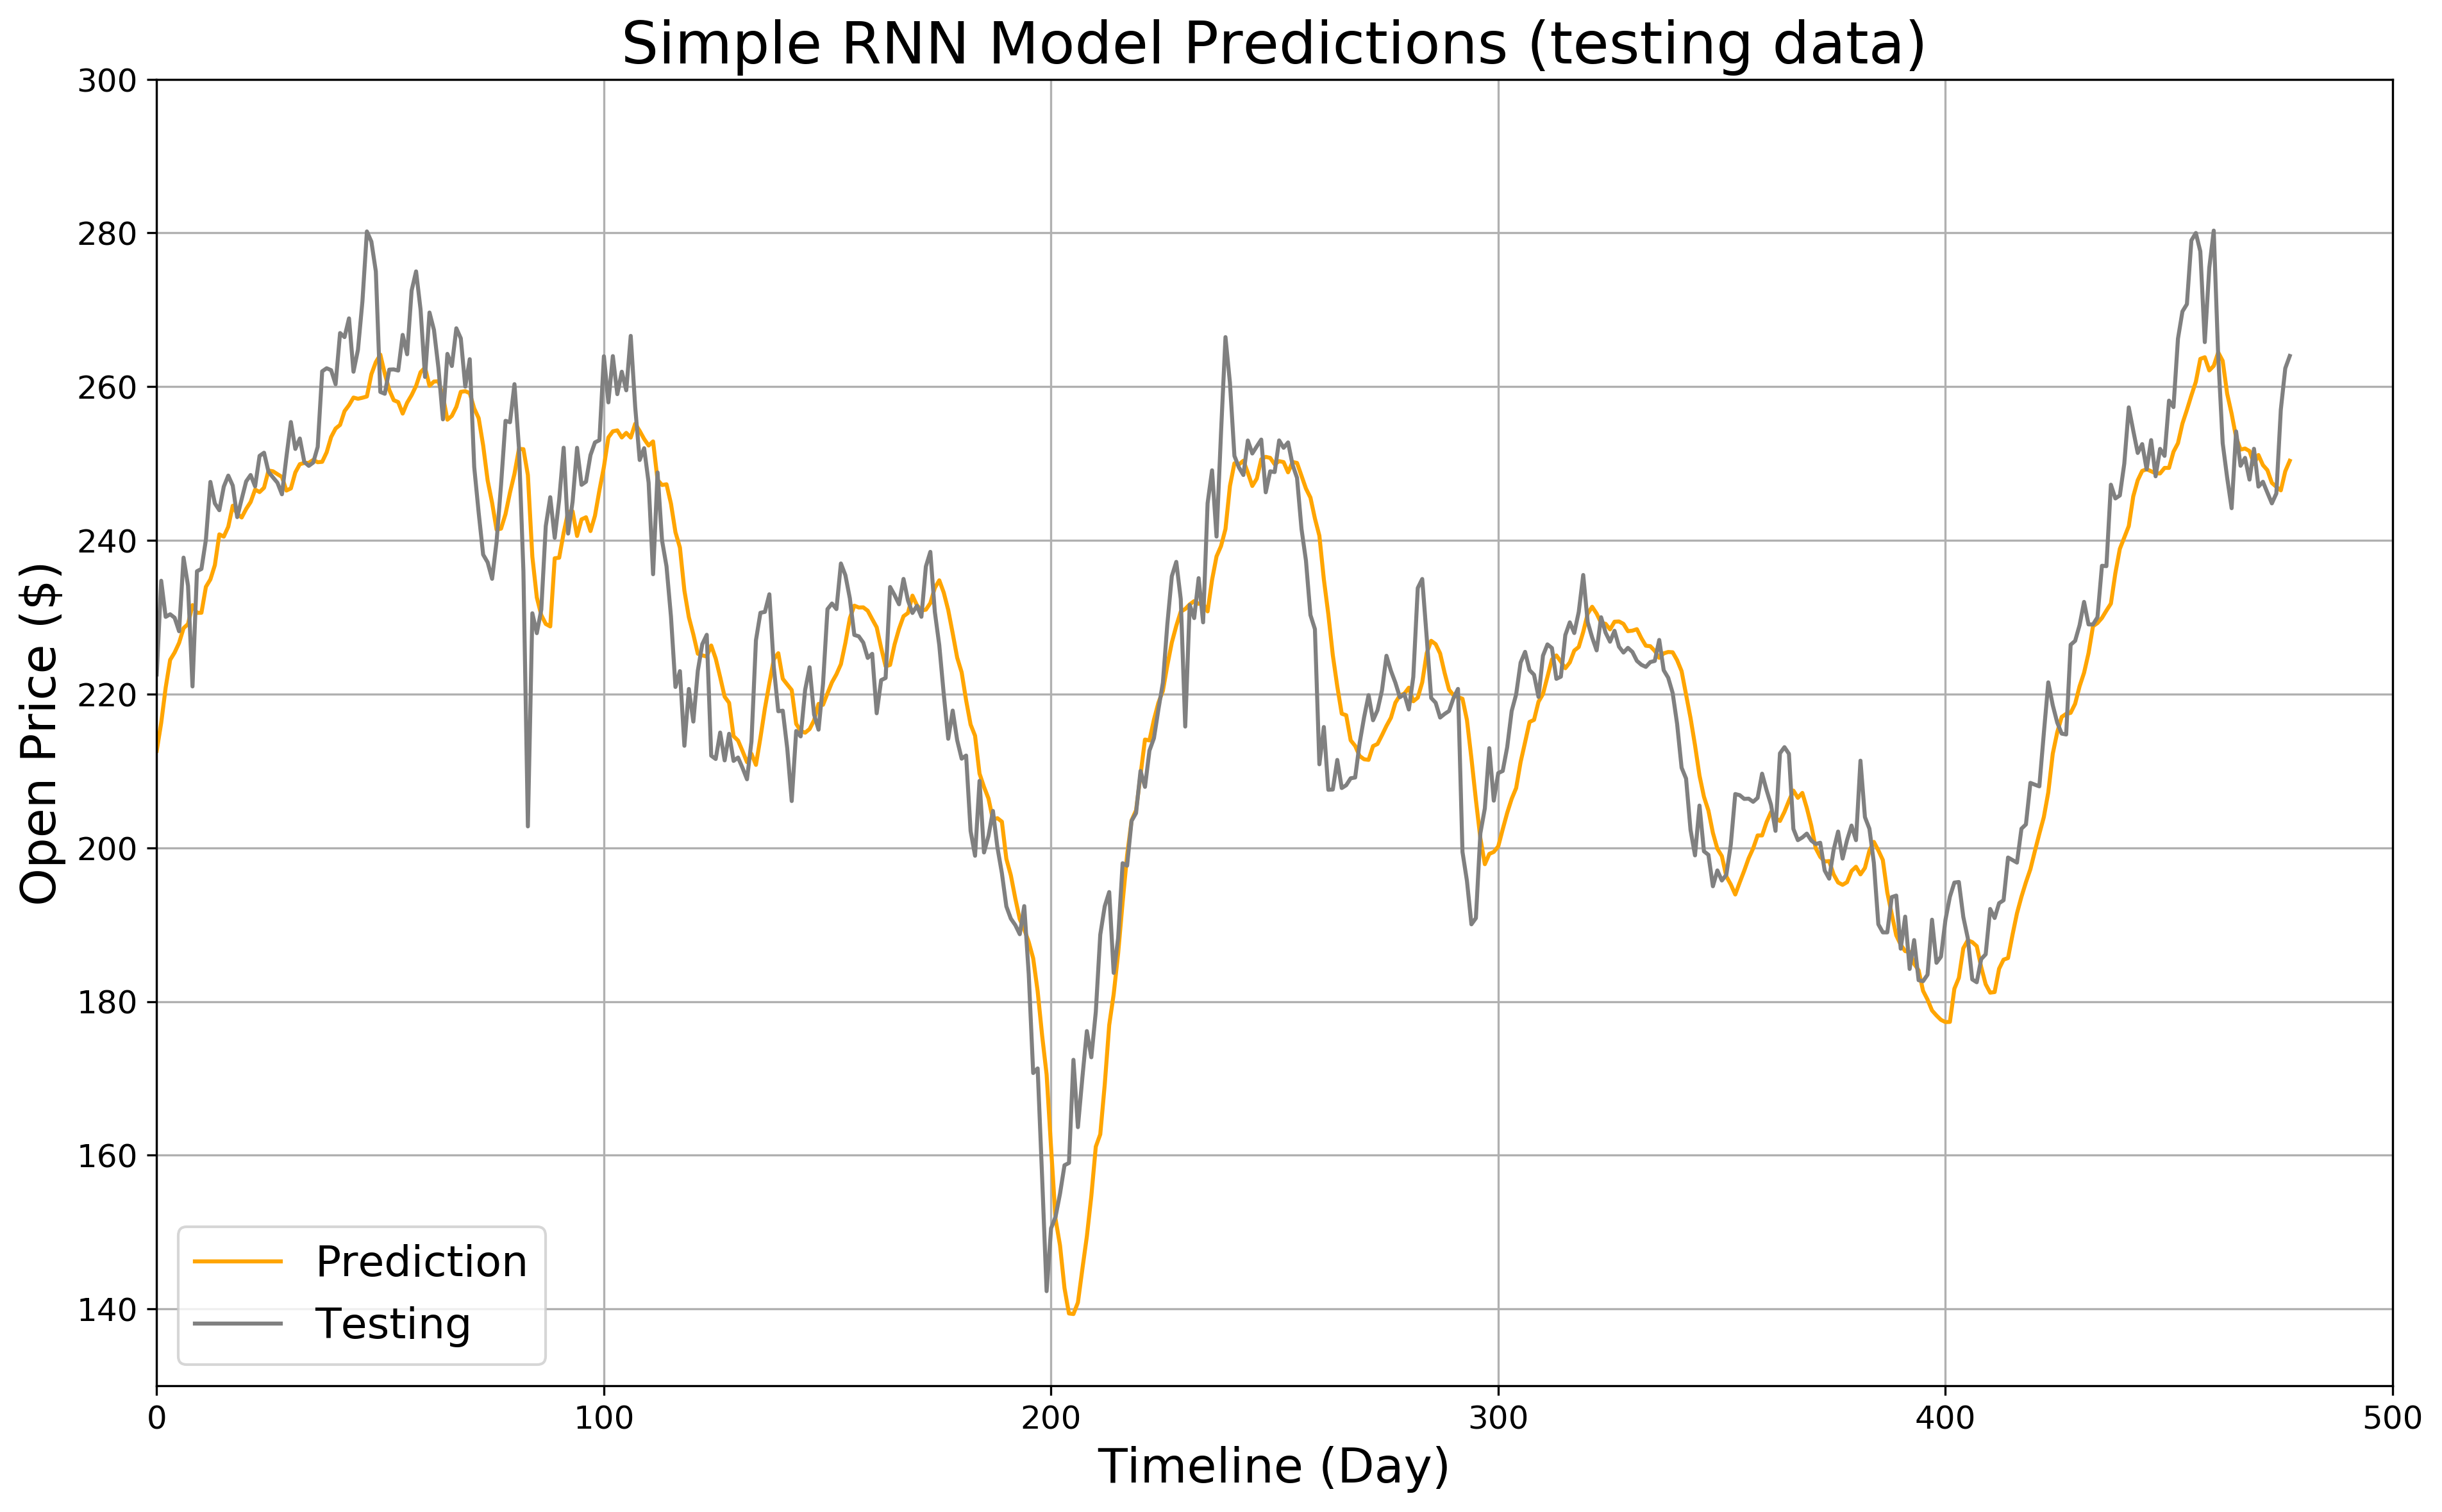

In [24]:
# present the prediction result with ground truth data (testing only)
plt.figure(figsize = (15,9), dpi=300)
plt.plot(y_pred_of_test_, label = 'Prediction', c = 'orange')
plt.plot(scaler.inverse_transform(y_test), label = 'Testing', c = 'gray')
plt.title('Simple RNN Model Predictions (testing data)', fontsize=22)
plt.xlabel('Timeline (Day)', fontsize=18)
plt.ylabel('Open Price ($)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.axis([0,500,130,300])
plt.grid(True)
plt.show()

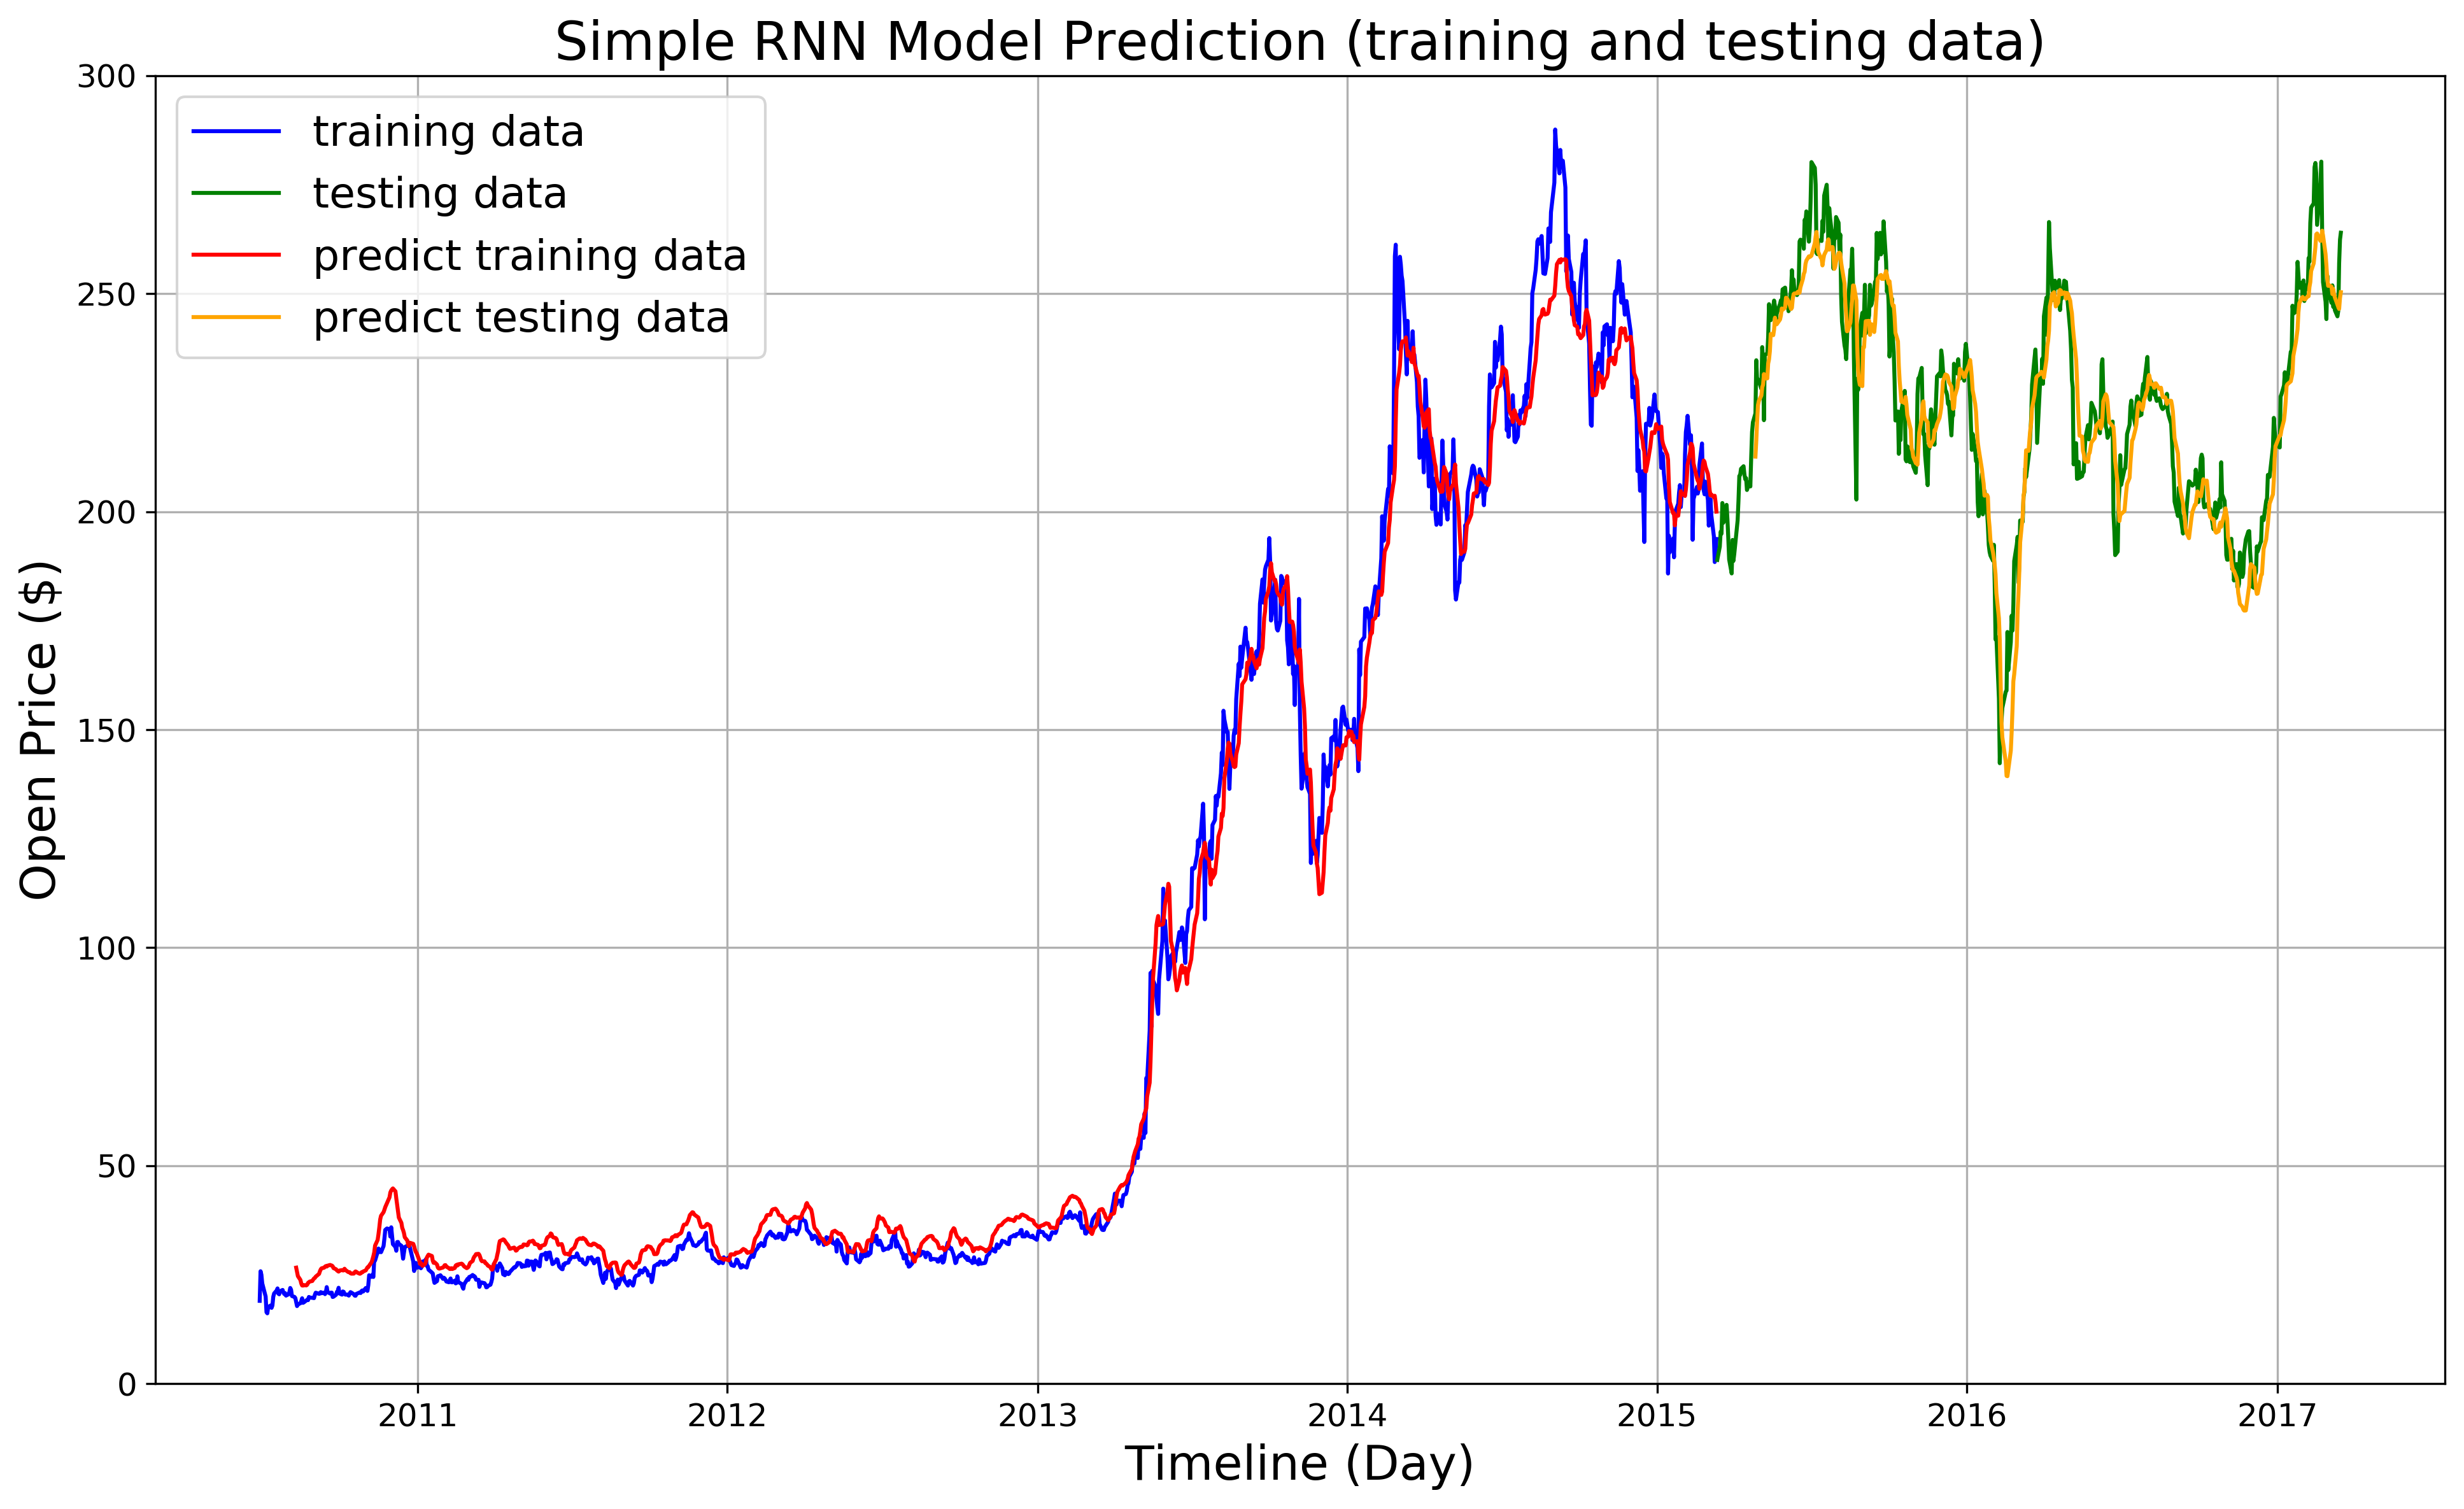

In [25]:
# present the prediction result with ground truth data (both training and testing)
plt.figure(figsize =(13,8), dpi=300)
plt.plot(train_data.Date, train_data.Open, label = 'training data', color = 'b')
plt.plot(testing_data.Date, testing_data.Open, label = 'testing data', color = 'g')

plt.plot(train_data.Date.iloc[time_step:], y_pred_, label = 'predict training data', color = 'r')
plt.plot(testing_data.Date.iloc[time_step:], y_pred_of_test_, label = 'predict testing data', color = 'orange')

plt.title('Simple RNN Model Prediction (training and testing data)', fontsize=20)
plt.xlabel('Timeline (Day)', fontsize=18)
plt.ylabel('Open Price ($)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.ylim([0,300])
plt.grid(True)

plt.tight_layout()
plt.show()

### <b>Build LSTM Model</b>

In [26]:
# import packages for LSTM
from keras.layers import LSTM
from keras import backend as K

In [28]:
# create LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 12, batch_size = 10)

Epoch 1/12
116/116 [==============================] - 3s 9ms/step - loss: 0.0094 - accuracy: 8.6655e-04
Epoch 2/12
116/116 [==============================] - 1s 9ms/step - loss: 0.0012 - accuracy: 8.6655e-04
Epoch 3/12
116/116 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 8.6655e-04
Epoch 4/12
116/116 [==============================] - 1s 9ms/step - loss: 9.2013e-04 - accuracy: 8.6655e-04
Epoch 5/12
116/116 [==============================] - 1s 9ms/step - loss: 0.0011 - accuracy: 8.6655e-04
Epoch 6/12
116/116 [==============================] - 1s 9ms/step - loss: 0.0013 - accuracy: 8.6655e-04
Epoch 7/12
116/116 [==============================] - 1s 9ms/step - loss: 7.8703e-04 - accuracy: 8.6655e-04
Epoch 8/12
116/116 [==============================] - 1s 9ms/step - loss: 8.2115e-04 - accuracy: 8.6655e-04
Epoch 9/12
116/116 [==============================] - 1s 9ms/step - loss: 8.1927e-04 - accuracy: 8.6655e-04
Epoch 10/12
116/116 [===========================

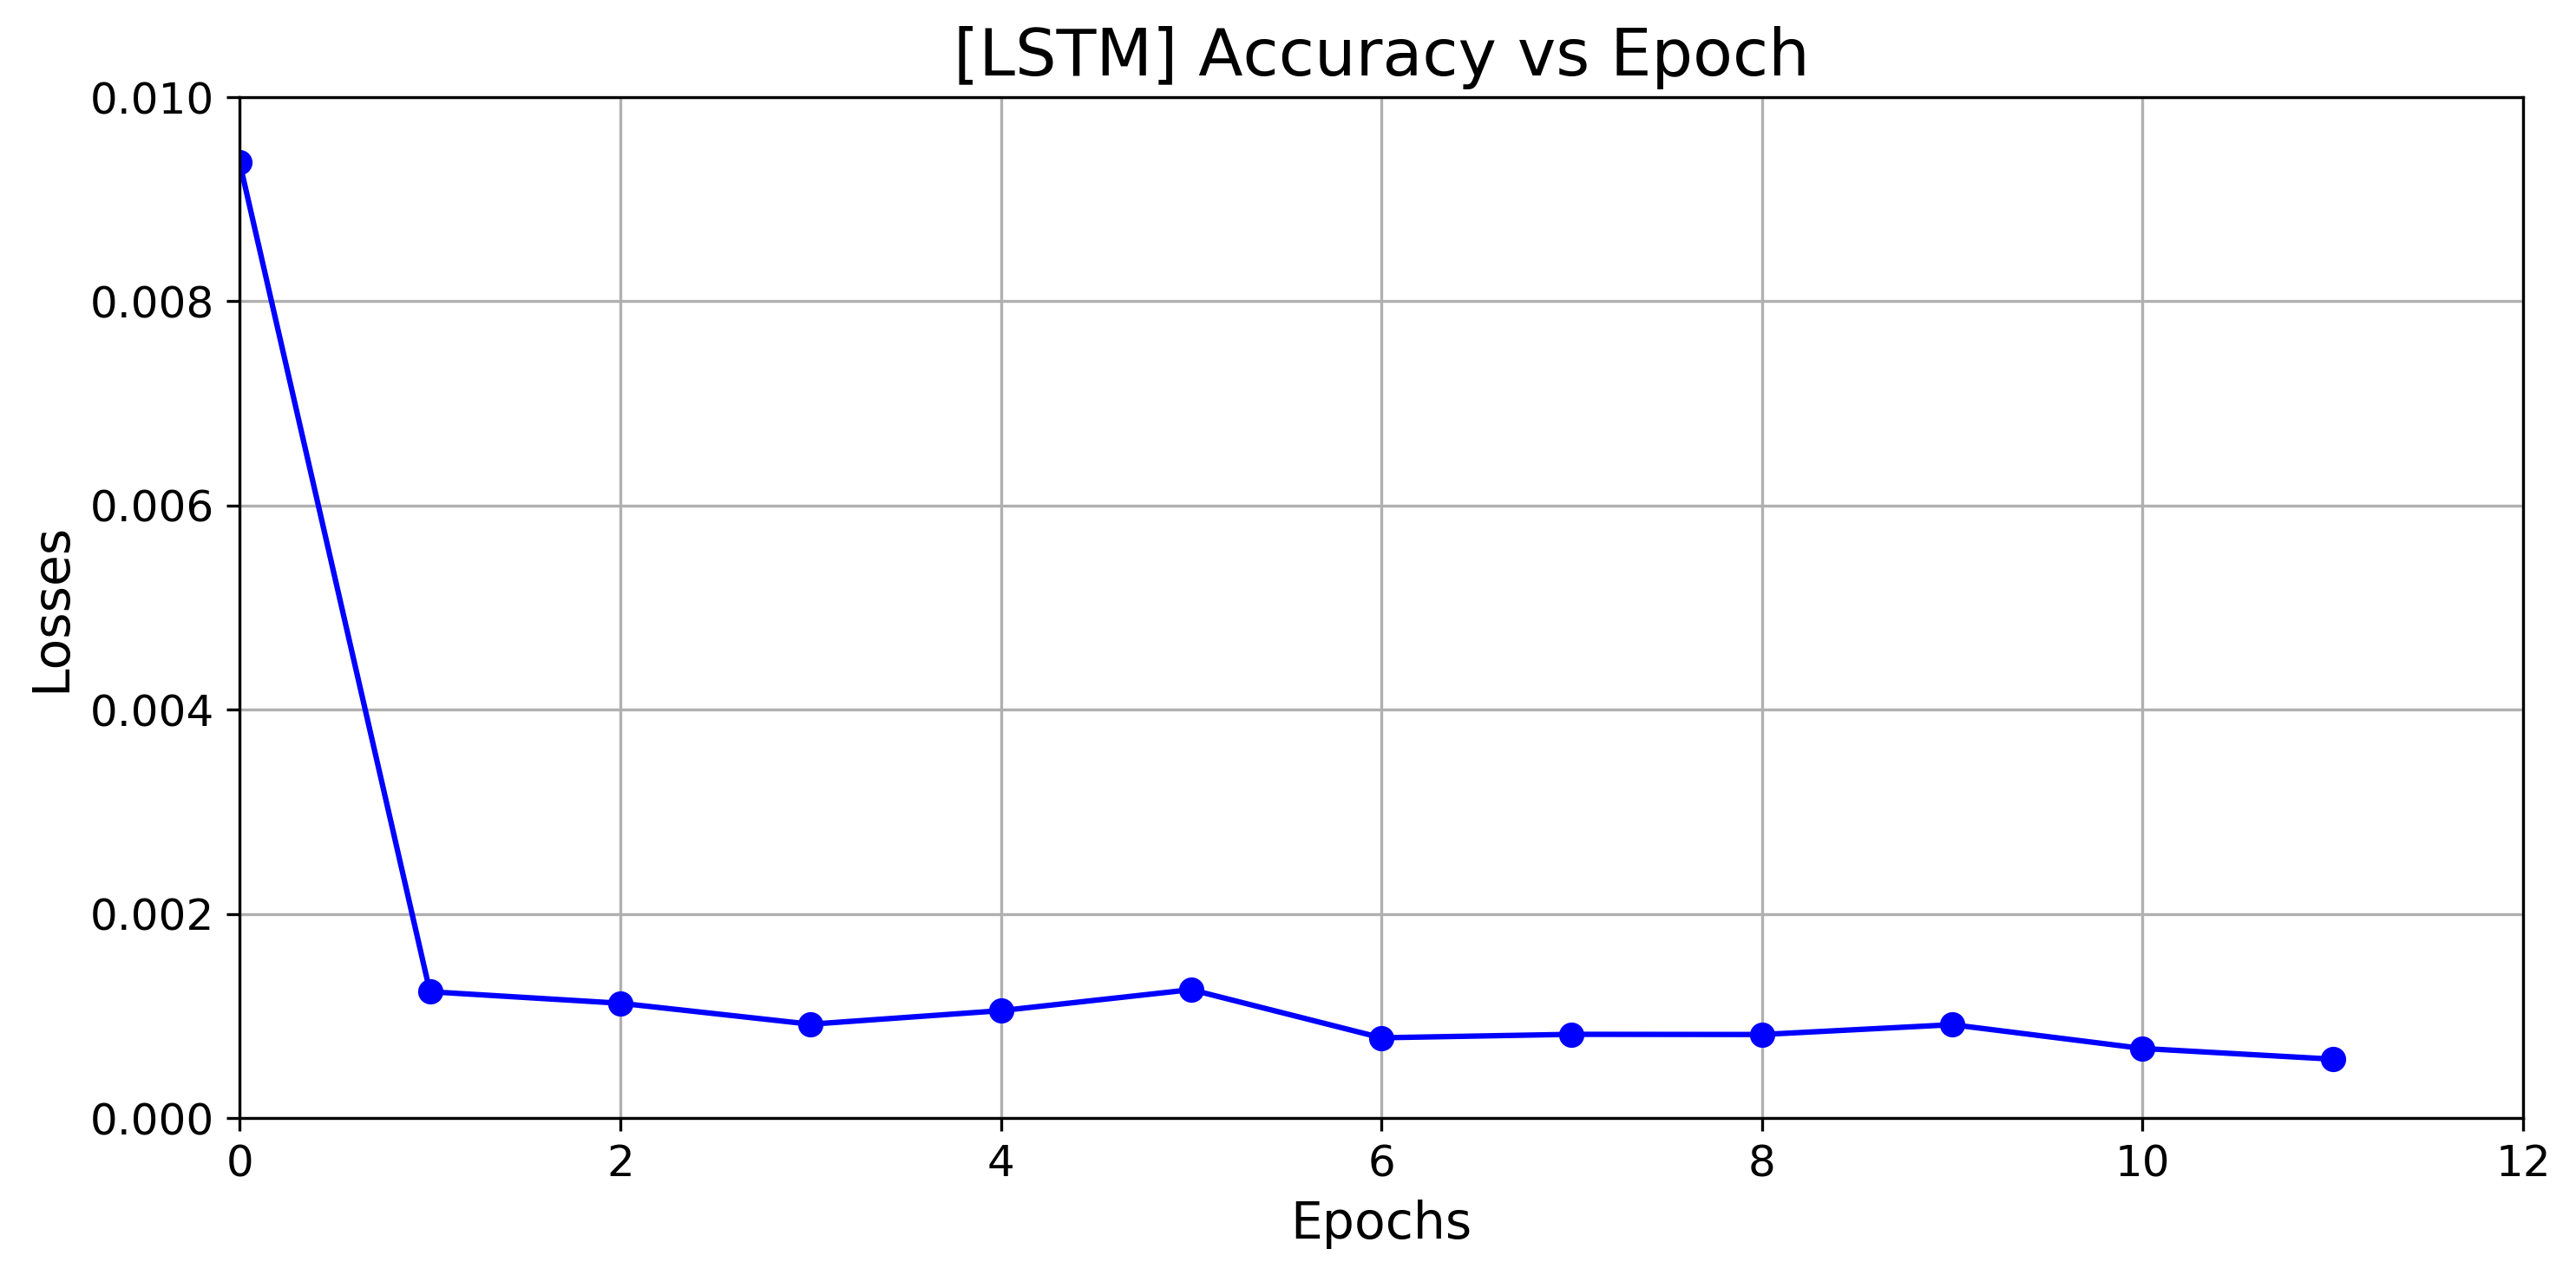

In [29]:
plt.figure(figsize =(10,5), dpi=300)
plt.plot(history2.history['loss'], 'bo-')
plt.title('[LSTM] Accuracy vs Epoch', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Losses', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axis([0,12,0,0.01])
plt.grid(True)
plt.tight_layout()
plt.show()

### <b>Predict Testing Data</b>

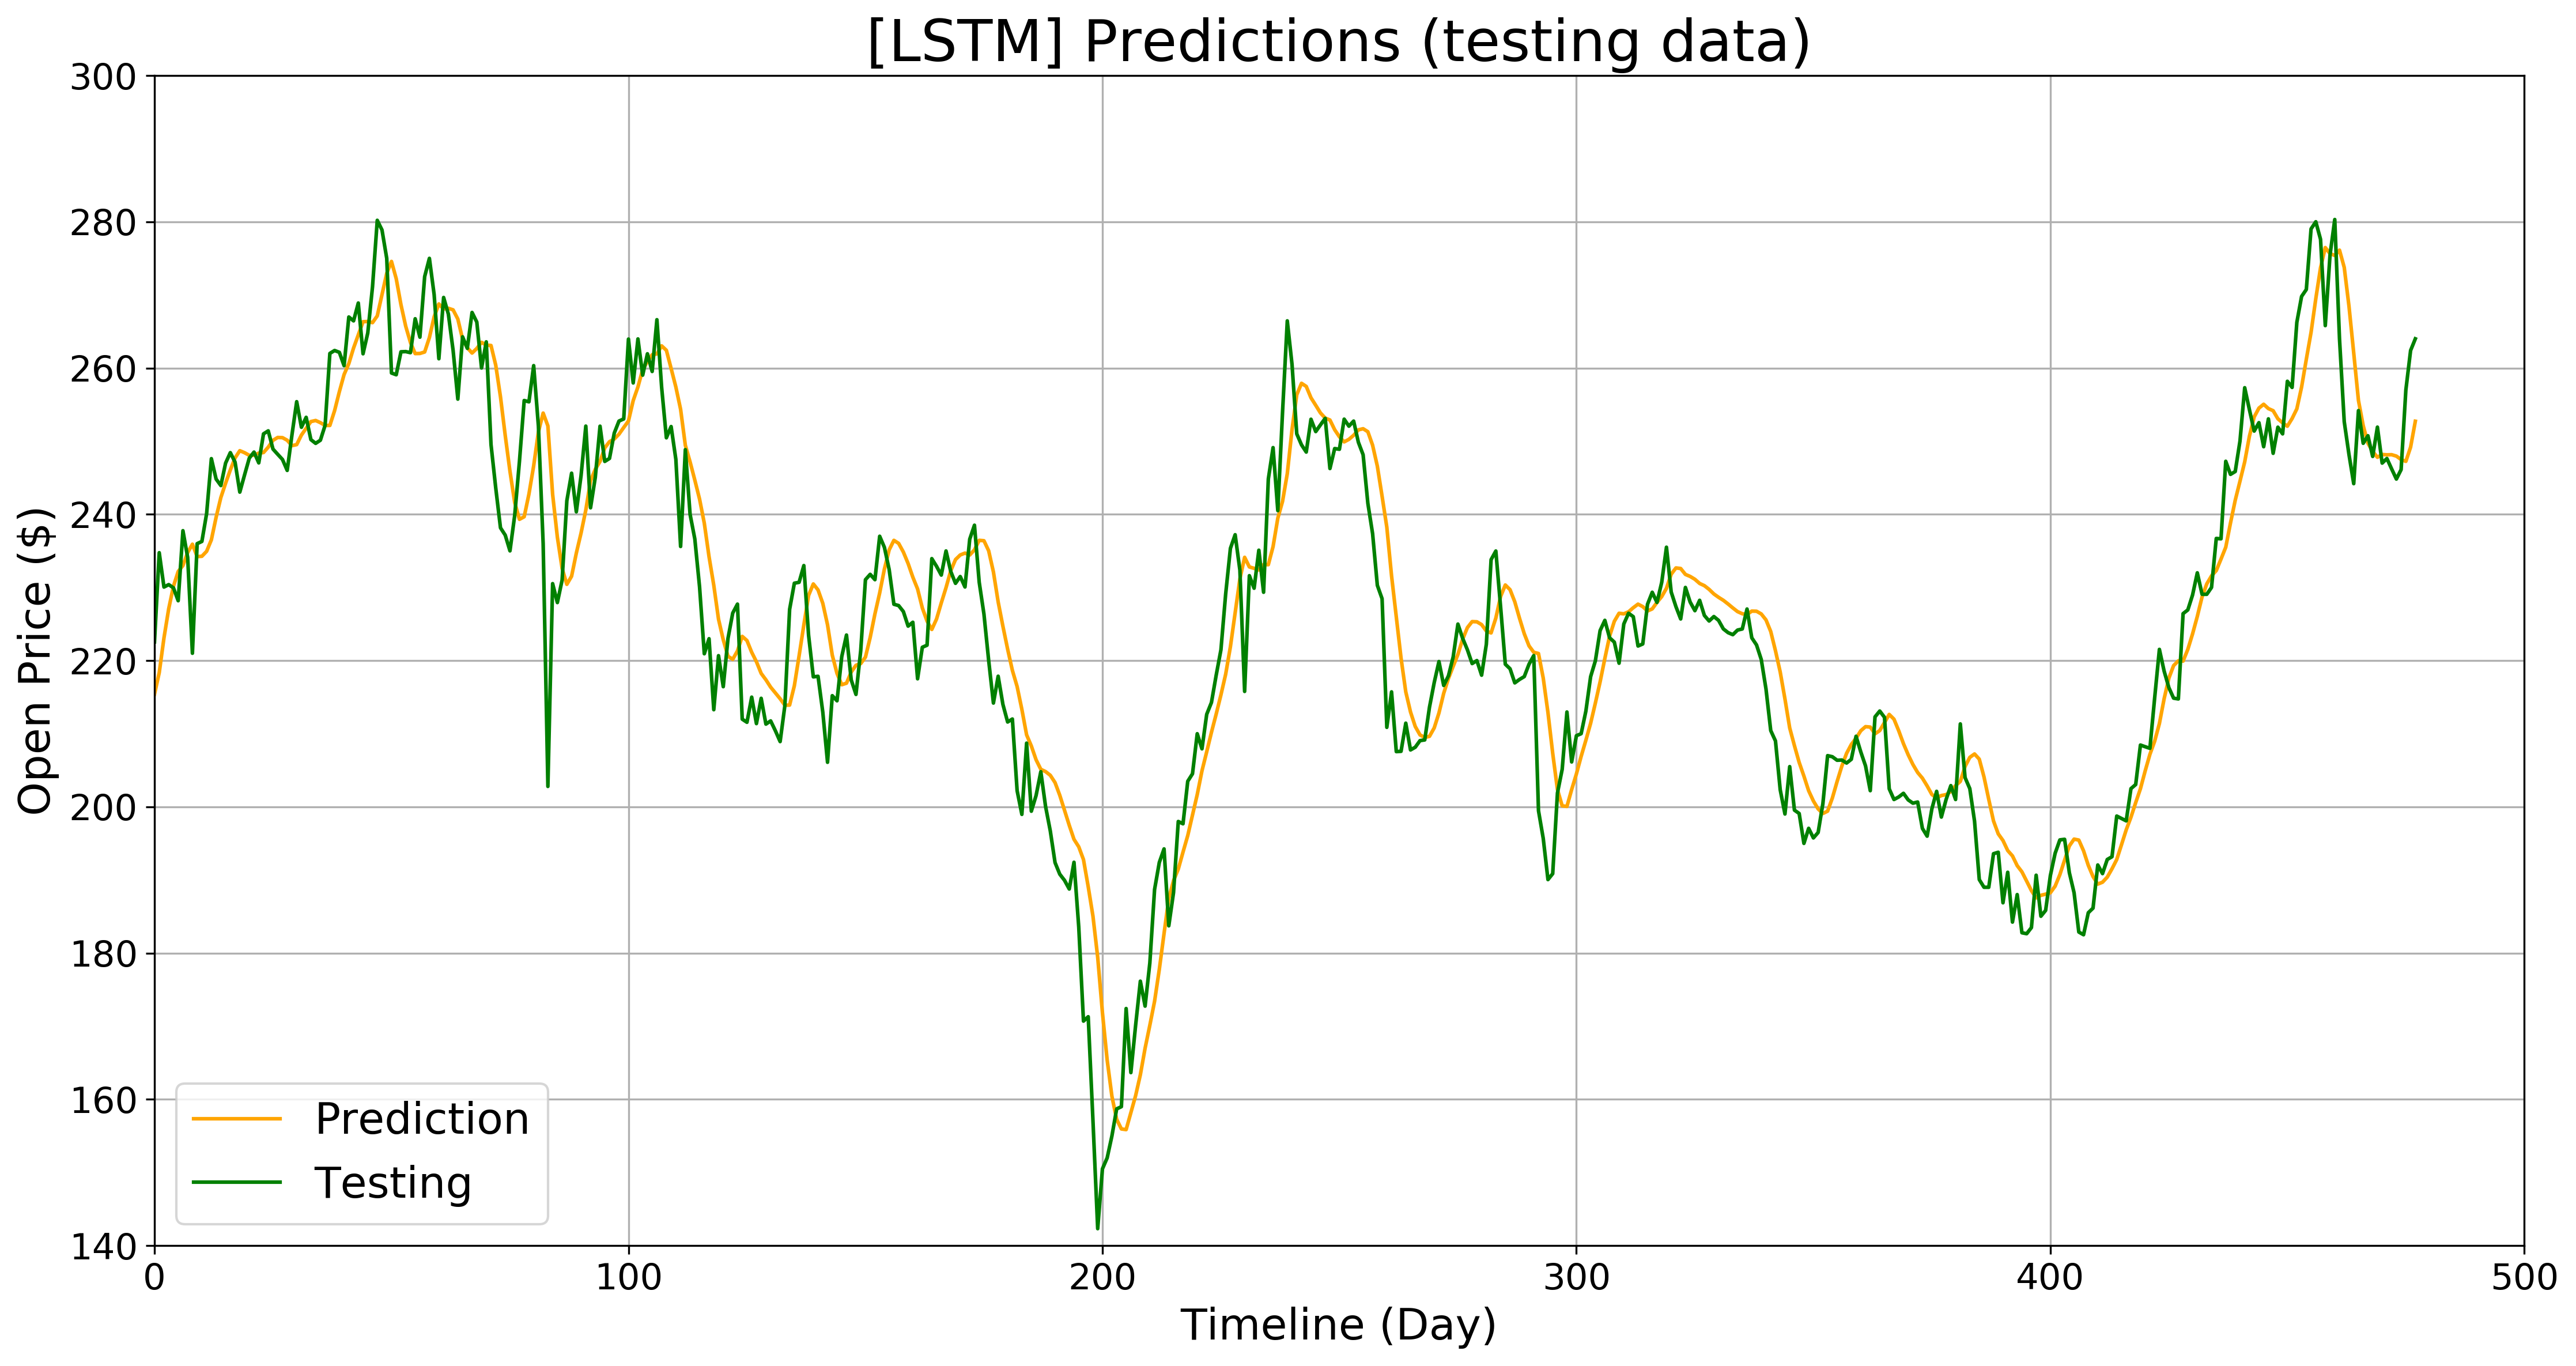

In [30]:
plt.figure(figsize =(15,8), dpi=300)
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = 'Prediction', c = 'orange')
plt.plot(scaler.inverse_transform(y_test), label = 'Testing', color = 'g')
plt.title('[LSTM] Predictions (testing data)', fontsize=24)
plt.xlabel('Timeline (Day)', fontsize=18)
plt.ylabel('Open Price ($)', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.axis([0,500,140,300])
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

### <b>Draw Model</b>

In [31]:
# import packages
import pydot
import graphviz
from keras.utils.vis_utils import plot_model

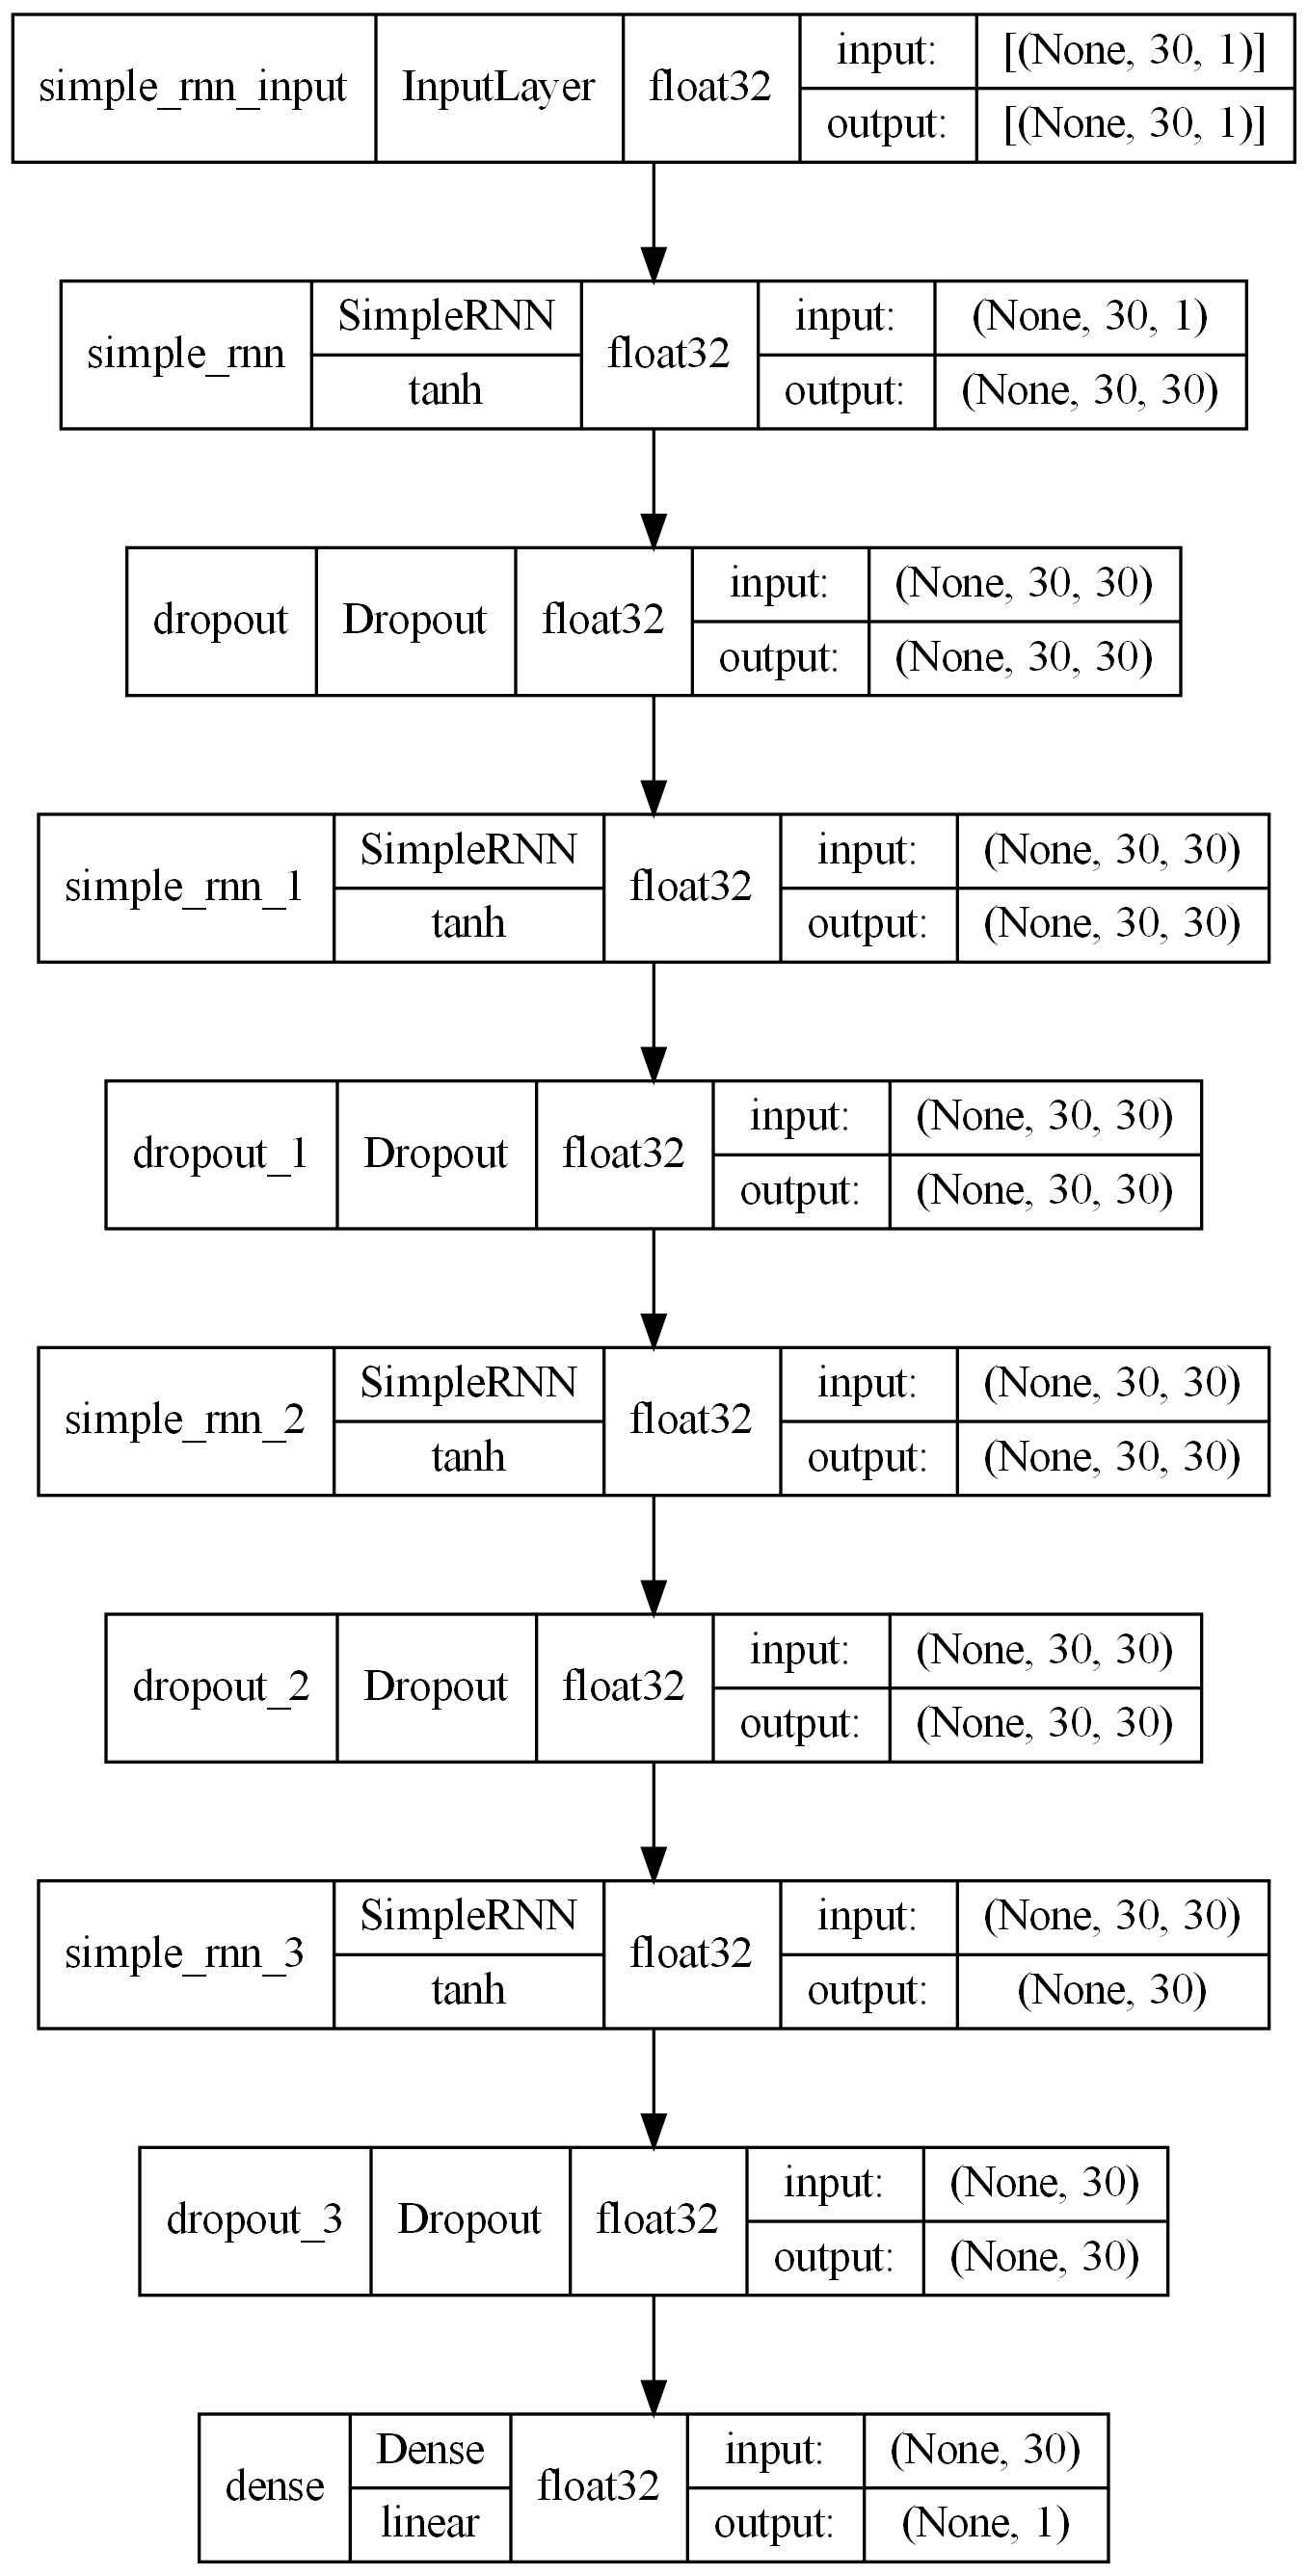

In [32]:
plot_model(regressor, show_shapes=True, show_dtype=True, 
           show_layer_activations=True, expand_nested=True, dpi=240)

In [33]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30, 30)            960       
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 dropout_1 (Dropout)         (None, 30, 30)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 30, 30)            1830      
                                                                 
 dropout_2 (Dropout)         (None, 30, 30)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30)                1

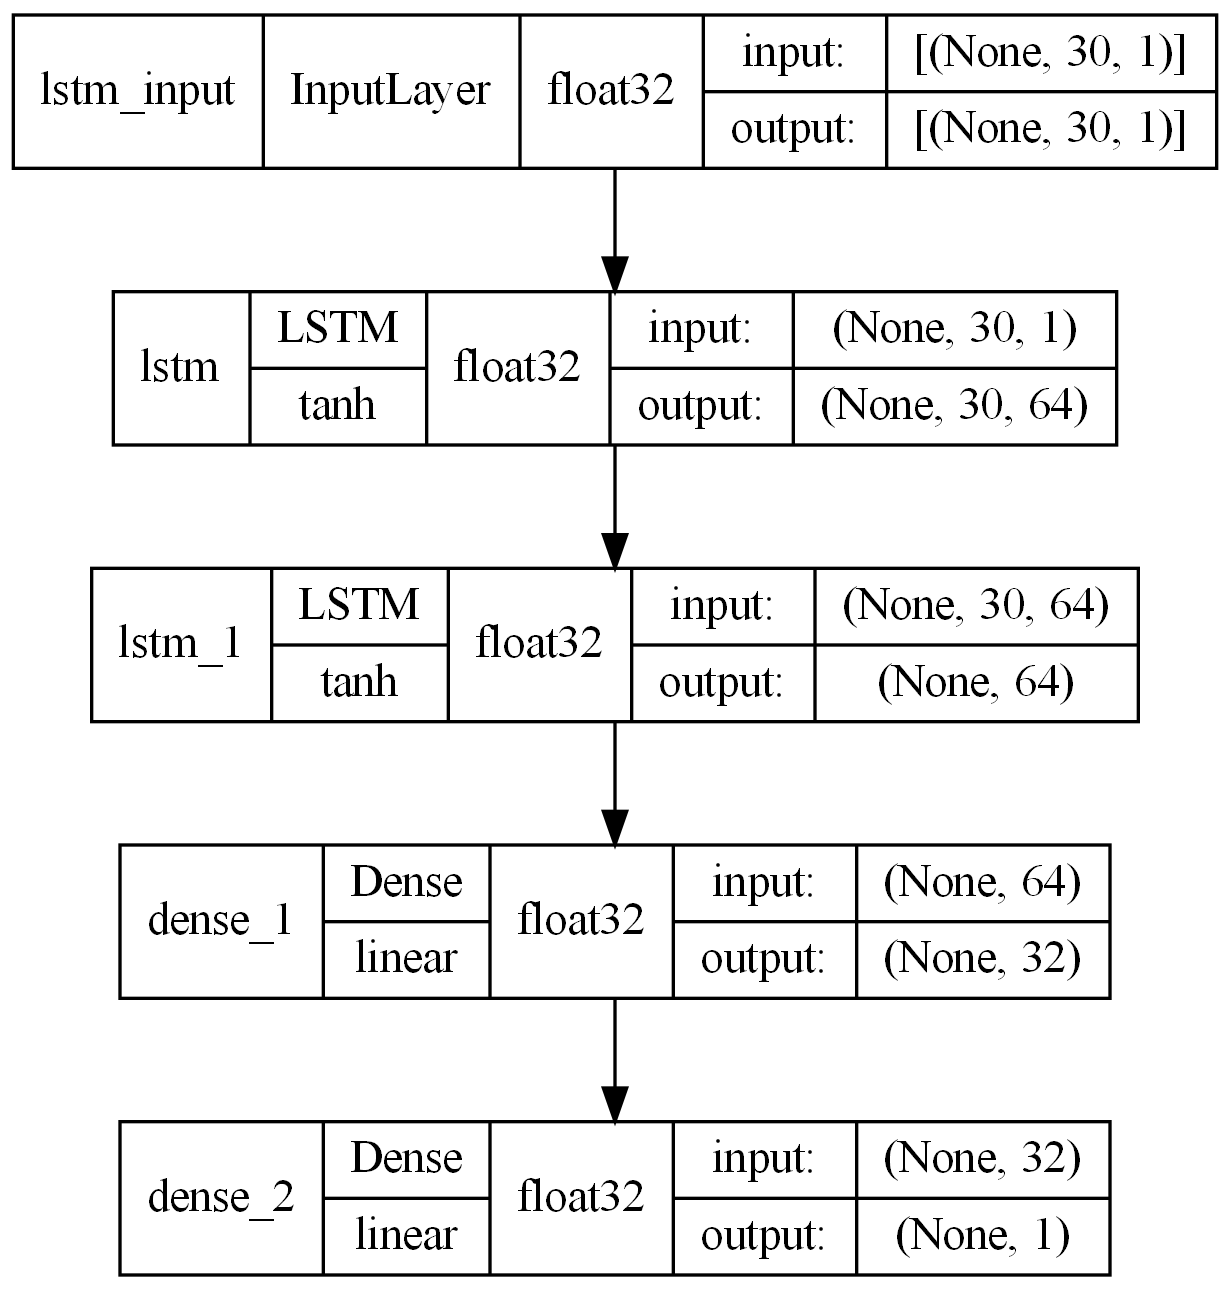

In [34]:
plot_model(model_lstm, show_shapes=True, show_dtype=True, 
           show_layer_activations=True, expand_nested=True, dpi=240)

In [35]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trainable params: 0
_________________________________________________________________
